This notebook contains to experiment with transfer leanring + custom classifier/GAP-softmax. With the possibility to apply fine tuning and to freeze portion of the network. All the experiments we have run can be implemented by modifying the configuraion object in the "Experiment environment" section

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_datasets as tfds
import datetime
import pickle
import time
from keras.utils.layer_utils import count_params

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, Rescaling, AveragePooling2D

tfk = tf.keras
tfkl = tf.keras.layers

# Data import 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Random seed for reproducibility
seed = 44

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Dataset folders 
dataset_dir = '../gdrive/MyDrive/ann_dataset'
dataset_folder = os.path.join(dataset_dir, 'ann_dataset')

test_folder = os.path.join(dataset_dir, 'test')
train_folder = os.path.join(dataset_dir, 'train')

In [ ]:
IMG_SHAPE = (96,96, 3)

In [ ]:
class_weight = {}

for i in range(8):
  class_weight[i] = 1.5 if i != 0 else 1

class_weight

{0: 1, 1: 1.5, 2: 1.5, 3: 1.5, 4: 1.5, 5: 1.5, 6: 1.5, 7: 1.5}

# Functions

In [ ]:
# count trainble not trainable parameters given a keras model
def count_w(model, context=""):
  trainable_count = count_params(model.trainable_weights)
  non_trainable_count = count_params(model.non_trainable_weights)
  print(f"\n{context}\nTrainable: \t\t{trainable_count}\nNon Trainable:  \t{non_trainable_count}")

In [ ]:
# function to add regularization on the pretrained part of the network
def add_regularization(model, regularizer):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      raise Exception("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
# wrapper function that return a model composed by  pretrained model + GAP softmax
def bottom_model_builder_fully_conv(
    base_model,
    dropout_rate,
    data_augmentation_layer,
    preprocessing_layer = None,
    preprocessing=False,
    data_aug = False
    ):

  inputs=tfk.Input(shape=IMG_SHAPE)
  x = inputs
  if data_aug:
    x = data_augmentation_layer(x)

  if preprocessing:
     x = preprocessing_layer(x)
  x = base_model(x)
  x = tfkl.GlobalAveragePooling2D()(x)
  x = Dropout(dropout_rate, name="top_dropout")(x)
  outputs = tfkl.Dense(
      8, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  return tl_model

In [ ]:
# wrapper function that return a model composed by  pretrained model + custom FFNN as classifier at the end
def bottom_model_builder_classifier(
    base_model,
    dropout_rate,
    data_augmentation_layer,
    preprocessing_layer = None,
    preprocessing=False,
    data_aug = False,
    size_dense =10000
    ):

  inputs=tfk.Input(shape=IMG_SHAPE)
  x = inputs
  if data_aug:
    x = data_augmentation_layer(x)

  if preprocessing:
     x = preprocessing_layer(x)
  x = base_model(x)
  x = tfkl.GlobalAveragePooling2D()(x)
  #x = Dropout(dropout_rate, name="top_dropout_1")(x)
  x = Dense(size_dense, activation='swish')(x)
  x = Dropout(dropout_rate, name="top_dropout_2")(x)
  x = Dense(256, activation='swish')(x)
  x = Dropout(dropout_rate, name="top_dropout_3")(x)
  outputs = tfkl.Dense(
      8, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  return tl_model

'def bottom_model_builder_classifier(\n    base_model,\n    dropout_rate,\n    data_augmentation_layer,\n    preprocessing_layer = None,\n    preprocessing=False,\n    data_aug = False,\n    size_dense =10000\n    ):\n\n  inputs=tfk.Input(shape=IMG_SHAPE)\n  x = inputs\n  if data_aug:\n    x = data_augmentation_layer(x)\n\n  if preprocessing:\n     x = preprocessing_layer(x)\n  x = base_model(x)\n  x = tfkl.GlobalAveragePooling2D()(x)\n  #x = Dropout(dropout_rate, name="top_dropout_1")(x)\n  x = Dense(size_dense, activation=\'swish\')(x)\n  x = Dropout(dropout_rate, name="top_dropout_2")(x)\n  x = Dense(256, activation=\'swish\')(x)\n  x = Dropout(dropout_rate, name="top_dropout_3")(x)\n  outputs = tfkl.Dense(\n      8, \n      activation=\'softmax\',\n      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)\n\n\n  # Connect input and output through the Model class\n  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name=\'model\')\n\n  return tl_model'

In [ ]:
# function containing all the logic for training a model given the setup data as parameter
def run_experiment(
    PATIENCE, 
    EPOCHS, 
    EXPERIMENT_NAME, 
    SELECTED_MODEL,
    DROPOUT,
    USE_DATA_AUG,
    FREEZE_PERCENT,
    REGULARIZER,
    BATCH_SIZE,
    PREPROCESSING,
    SAVE_ACCURACY,
    PRE_TRAIN_CLASSIFIER,
    AUG_LAYER,
    L_RATE_FINETUNING,
    DROPOUT_RATE_CLASSIFIER):
  
  # not parameters to set
  USE_REG = REGULARIZER is not None
  USE_PREPROCESSING = PREPROCESSING is not None
  history_pretraining ={}

  # data aumentation function default
  data_augmentation_layer = AUG_LAYER
  
  # callback list
  callbacks_list = []
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True)
  callbacks_list.append(es_callback)

  # metrics
  metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
  ]


  # build train and validation dataset and activate prefetching 
  train_dataset = tfk.utils.image_dataset_from_directory(
      directory=train_folder,
      labels="inferred",
      label_mode="categorical",
      color_mode='rgb',
      image_size=(96,96),
      batch_size=BATCH_SIZE
  )
  validation_dataset = tfk.utils.image_dataset_from_directory(
      directory=test_folder,
      labels="inferred",
      label_mode="categorical",
      color_mode='rgb',
      image_size=(96,96),
  )
  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  # create base model
  base_model = SELECTED_MODEL(input_shape=IMG_SHAPE,
                              include_top=False,
                              weights='imagenet',
                              drop_connect_rate=DROPOUT)
  
  if PRE_TRAIN_CLASSIFIER:
    print("\nPre training activated")
    # freeze the imported feature extractor and train only classifier
    base_model.trainable = False
    trainable_count = count_params(base_model.trainable_weights)
    non_trainable_count = count_params(base_model.non_trainable_weights)
    print(f"\nBase model before Pretraining\nTrainable: \t\t{trainable_count}\nNon Trainable:  \t{non_trainable_count}")

    if trainable_count != 0:
      raise Exception('Trainable parameter are not zero! During pretraining the base model should be completely freezed')

    model = bottom_model_builder_fully_conv(
      base_model = base_model,
      data_augmentation_layer = data_augmentation_layer,
      preprocessing_layer=PREPROCESSING,
      data_aug=USE_DATA_AUG,
      preprocessing=USE_PREPROCESSING,
      dropout_rate=DROPOUT_RATE_CLASSIFIER
      )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(), 
        loss=tfk.losses.CategoricalCrossentropy(), 
        metrics=metrics
        )
    
    # train only classifier (forced low patience)
    history_pretraining = model.fit(
      train_dataset,
      epochs = EPOCHS,
      validation_data = validation_dataset,
      callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)],
      class_weight=class_weight
      ).history

    print(f"\nPretrain ended with val accuracy: {np.max(history_pretraining['val_accuracy'])}")

    # restore base model to trainable
    base_model.trainable = True
    # set everything trainable in the model
    model.trainable = True

  trainable_count = count_params(base_model.trainable_weights)
  non_trainable_count = count_params(base_model.non_trainable_weights)
  print(f"\nBefore Freeze\nTrainable: \t\t{trainable_count}\nNon Trainable:  \t{non_trainable_count}")

  # select percentage to freeze
  len_network = len(base_model.layers)
  freeze_n = int(len_network * FREEZE_PERCENT)
  print(f"\nnetwrok size {len_network} freezed layers -> {freeze_n}")

  # freeze top n layers
  for layer in base_model.layers[:freeze_n]:
      layer.trainable = False

  # force all batch normalization to be non trainable
  for layer in base_model.layers:
    if isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = False

  trainable_count = count_params(base_model.trainable_weights)
  non_trainable_count = count_params(base_model.non_trainable_weights)
  print(f"\nAfter Freeze\nTrainable: \t\t{trainable_count}\nNon Trainable:  \t{non_trainable_count}")


  if not PRE_TRAIN_CLASSIFIER:
    # if there is no pretrain create the model here and compile with standard learning rate
    model = bottom_model_builder_fully_conv(
        base_model = base_model,
        data_augmentation_layer = data_augmentation_layer,
        preprocessing_layer=PREPROCESSING,
        data_aug=USE_DATA_AUG,
        preprocessing=USE_PREPROCESSING,
        dropout_rate=DROPOUT_RATE_CLASSIFIER
        )
    
    # add regulariazation
    if USE_REG:
      model = add_regularization(model, regularizer=REGULARIZER)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(), 
        loss=tfk.losses.CategoricalCrossentropy(), 
        metrics=metrics
        )

  else:
    count_w(model, "Compiled model for fine tuning")

    # add regulariazation
    if USE_REG:
      model = add_regularization(model, regularizer=REGULARIZER)

    # compile again with lower learnign rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(L_RATE_FINETUNING), 
        loss=tfk.losses.CategoricalCrossentropy(), 
        metrics=metrics
        )

  # start training
  history = model.fit(
      train_dataset,
      epochs = EPOCHS,
      validation_data = validation_dataset,
      callbacks = callbacks_list,
      class_weight=class_weight
      ).history
  

  if np.max(history['val_accuracy']) > SAVE_ACCURACY:
    print(f"\n ** GOOD MODEL FOUND **")
    model_name = f"Model_{EXPERIMENT_NAME}{int(time.time())}{np.max(history['val_accuracy']):.4}"
    model.save(model_name)

  return history, history_pretraining

# Experiment environment

In [ ]:
# ********************* SETUP OF THE LOOP *************************
fixed_params = {
  'EXPERIMENT_NAME' : "name",
  'SELECTED_MODEL' : tfk.applications.EfficientNetB4,
  'SAVE_ACCURACY': 0.88,
  'PATIENCE' : 25,
  'EPOCHS' : 500,
  'PRE_TRAIN_CLASSIFIER': True,
  'USE_DATA_AUG' : True,
  'BATCH_SIZE' : 64,
  'PREPROCESSING' : None, # example -> tf.keras.applications.mobilenet_v2.preprocess_input
  'FREEZE_PERCENT':0.05,
  'L_RATE_FINETUNING' : 1e-5,
  'AUG_LAYER' : Sequential([
                  tf.keras.layers.RandomFlip(),
                  tf.keras.layers.RandomRotation(0.3),
                  ]),
  'REGULARIZER' : tfk.regularizers.L2(0.05)
}

# They list must have same size
params_grid = {
    'DROPOUT_RATE_CLASSIFIER': [0.3],
    'DROPOUT':[0.2],
  }

# ************** END SETUP ****************
l = 0
for _, value in params_grid.items():
  if l == 0:
    l = len(value)
  if l != len(value):
    raise Exception("Param grid bad format all lenghts should be the same")

In [ ]:
history_name =  f"history_list{int(time.time())}.p"

In [ ]:
# run loop
history_metadata = []
histories = []
for i in range(l):
  tmp_grid = {}
  for item, value in params_grid.items():
    tmp_grid[item] = value[i]
  
  print(f"experiment: {tmp_grid}\n")

  histories.append(run_experiment(**fixed_params, **tmp_grid))
  history_metadata.append(tmp_grid)

  with open(history_name, "wb" ) as f:
    pickle.dump( histories, f)
  with open("metadata" + history_name, "wb" ) as f:
    pickle.dump( "metadata" + history_name, f)

  # check point on drive
  !zip -r ../gdrive/MyDrive/Ann_Challenge/Experiments/HistCheckpoint.zip {history_name}
  !zip -r ../gdrive/MyDrive/Ann_Challenge/Experiments/MetaCheckpoint.zip {"metadata" + history_name}

experiment: {'DROPOUT_RATE_CLASSIFIER': 0.3, 'DROPOUT': 0.2}

Found 3624 files belonging to 8 classes.
Found 719 files belonging to 8 classes.

Pre training activated

Base model before Pretraining
Trainable: 		0
Non Trainable:  	17673823
Epoch 1/500
57/57 [==============================] - 29s 266ms/step - loss: 2.3618 - accuracy: 0.3761 - val_loss: 1.3795 - val_accuracy: 0.4771
Epoch 2/500
57/57 [==============================] - 8s 139ms/step - loss: 1.8980 - accuracy: 0.5105 - val_loss: 1.2930 - val_accuracy: 0.5216
Epoch 3/500
57/57 [==============================] - 8s 139ms/step - loss: 1.7711 - accuracy: 0.5433 - val_loss: 1.2280 - val_accuracy: 0.5452
Epoch 4/500
57/57 [==============================] - 8s 139ms/step - loss: 1.6829 - accuracy: 0.5637 - val_loss: 1.1936 - val_accuracy: 0.5647
Epoch 5/500
57/57 [==============================] - 8s 140ms/step - loss: 1.6434 - accuracy: 0.5872 - val_loss: 1.1433 - val_accuracy: 0.5855
Epoch 6/500
57/57 [==========================

  adding: history_list1669211751.p (deflated 59%)
  adding: metadatahistory_list1669211751.p (stored 0%)


# Save and evaluate part

In [ ]:
!zip -r ../gdrive/MyDrive/Ann_Challenge/Experiments/Model088.zip Model_name16692059570.8873

  adding: Model_name16692059570.8873/ (stored 0%)
  adding: Model_name16692059570.8873/variables/ (stored 0%)
  adding: Model_name16692059570.8873/variables/variables.index (deflated 78%)
  adding: Model_name16692059570.8873/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Model_name16692059570.8873/assets/ (stored 0%)
  adding: Model_name16692059570.8873/saved_model.pb (deflated 92%)
  adding: Model_name16692059570.8873/keras_metadata.pb (deflated 96%)


In [ ]:
!zip -r ../gdrive/MyDrive/Ann_Challenge/Experiments/Model009B.zip Model_name16691224010.9054

  adding: Model_name16691224010.9054/ (stored 0%)
  adding: Model_name16691224010.9054/saved_model.pb (deflated 92%)
  adding: Model_name16691224010.9054/variables/ (stored 0%)
  adding: Model_name16691224010.9054/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Model_name16691224010.9054/variables/variables.index (deflated 78%)
  adding: Model_name16691224010.9054/keras_metadata.pb (deflated 96%)
  adding: Model_name16691224010.9054/assets/ (stored 0%)


In [ ]:
history_metadata

[{'REGULARIZER': None, 'DROPOUT': 0.0, 'DROPOUT_RATE_CLASSIFIER': 0.0},
 {'REGULARIZER': None, 'DROPOUT': 0.0, 'DROPOUT_RATE_CLASSIFIER': 0.2},
 {'REGULARIZER': None, 'DROPOUT': 0.0, 'DROPOUT_RATE_CLASSIFIER': 0.4},
 {'REGULARIZER': None, 'DROPOUT': 0.4, 'DROPOUT_RATE_CLASSIFIER': 0.0},
 {'REGULARIZER': None, 'DROPOUT': 0.4, 'DROPOUT_RATE_CLASSIFIER': 0.2},
 {'REGULARIZER': None, 'DROPOUT': 0.4, 'DROPOUT_RATE_CLASSIFIER': 0.4},
 {'REGULARIZER': <keras.regularizers.L2 at 0x7fe82f0c70d0>,
  'DROPOUT': 0.0,
  'DROPOUT_RATE_CLASSIFIER': 0.0},
 {'REGULARIZER': <keras.regularizers.L2 at 0x7fe82f0c70d0>,
  'DROPOUT': 0.0,
  'DROPOUT_RATE_CLASSIFIER': 0.2},
 {'REGULARIZER': <keras.regularizers.L2 at 0x7fe82f0c70d0>,
  'DROPOUT': 0.0,
  'DROPOUT_RATE_CLASSIFIER': 0.4},
 {'REGULARIZER': <keras.regularizers.L2 at 0x7fe82f0c70d0>,
  'DROPOUT': 0.4,
  'DROPOUT_RATE_CLASSIFIER': 0.0},
 {'REGULARIZER': <keras.regularizers.L2 at 0x7fe82f0c70d0>,
  'DROPOUT': 0.4,
  'DROPOUT_RATE_CLASSIFIER': 0.2},
 {'

In [ ]:
history_name =  f"history_list{int(time.time())}.p"
with open(history_name, "wb" ) as f:
  pickle.dump( histories, f)
with open("metadata" + history_name, "wb" ) as f:
  pickle.dump( "metadata" + history_name, f)

In [ ]:
from google.colab import files
#files.download(history_name)
files.download("metadata" + history_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
[np.max(x['val_accuracy']) for x,y in histories]

[0.8845618963241577]

In [ ]:
!zip -r ../gdrive/MyDrive/Ann_Challenge/Experiments/Model_zip_8846.zip Model_name16692154860.8846

  adding: Model_name16692154860.8846/ (stored 0%)
  adding: Model_name16692154860.8846/variables/ (stored 0%)
  adding: Model_name16692154860.8846/variables/variables.index (deflated 78%)
  adding: Model_name16692154860.8846/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Model_name16692154860.8846/assets/ (stored 0%)
  adding: Model_name16692154860.8846/saved_model.pb (deflated 92%)
  adding: Model_name16692154860.8846/keras_metadata.pb (deflated 96%)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

def show_confusion(model, validation_dataset):
  Y_pred = model.predict(validation_dataset)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test= np.concatenate([np.argmax(y, axis=1) for x, y in validation_dataset], axis=0)

  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  f1_scores = f1_score(y_test, y_pred, average=None)
  mean_f1 = np.mean(f1_scores)

  print(f"\nF1 scores: {f1_scores}")
  print(f"\nMean F1 : {mean_f1}")
  print(f"\nAccuracy : {accuracy_score(y_test, y_pred)}")

In [ ]:
model_a = tf.keras.models.load_model('Model_name16692154860.8846')

In [ ]:
  batch_size = 64
  train_dataset = tfk.utils.image_dataset_from_directory(
      directory=train_folder,
      labels="inferred",
      label_mode="categorical",
      color_mode='rgb',
      image_size=(96,96),
      batch_size=batch_size
  )
  validation_dataset = tfk.utils.image_dataset_from_directory(
      directory=test_folder,
      labels="inferred",
      label_mode="categorical",
      color_mode='rgb',
      image_size=(96,96),
  )
  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 3624 files belonging to 8 classes.
Found 719 files belonging to 8 classes.


23/23 [==============================] - 1s 43ms/step


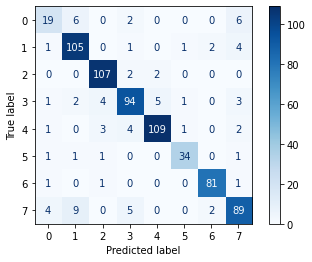


F1 scores: [0.62295082 0.88607595 0.94273128 0.86238532 0.92372881 0.90666667
 0.95857988 0.82790698]

Mean F1 : 0.8663782132875195

Accuracy : 0.8873435326842837


In [ ]:
show_confusion(model_a, validation_dataset)